# Beta VAE  

## Steps  
1. Import libraries  
2. Prepare data  
   ```Download  |  Transform  |  Dataloader```  
3. Define parameters  
   ```Model  |  Optimizer  |  Loss  |  Training  ```
4. Build Model  
   ```Components  ```
5. Training loop  
6. Visualize results  

## Import libraries  

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F    # New import
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime

print(f"Imports completed at {datetime.datetime.now()}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Versions
print(f"Torch: {torch.__version__}, TorchVision: {torchvision.__version__}")

Imports completed at 2025-08-22 18:07:07.931812
Using device: cuda
Torch: 2.6.0+cu124, TorchVision: 0.21.0+cu124


## Define parameters  

In [2]:
# Set seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Data prep params
batch_size = 128

# Model params
latent_dim = 20
beta_vae = 4.0

# Optimizer params
learning_rate = 0.0002
# beta1 = 0.5  # Adam optimizer beta1

# # Loss params
# criterion = nn.BCELoss()

# Training params
num_epochs = 20

## Prepare data  

In [3]:
# Transform
transform = transforms.ToTensor()
print(f"Transform to be applied:\n{transform}\n")

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train data:\n{train_dataset}\n")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Last batch will be 96 (6000 % 128) instead of 128, so drop to avoid problem with batch norm
print(f"Data loader:\n{train_loader}")

Transform to be applied:
ToTensor()

Train data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Data loader:


## Build Model  
```Beta VAE```  

**Probabilistic Neural Networks**  

- Encoder
    - Takes image, outputs mean and log var of latent space dim  
- Reparametrization (z-sampler)
    - Takes the mean and log var output by the Encoder and creates new z using epsilon (latent dim) from std normal  
- Decoder
    - Takes the z and outputs mean of x_hat (note that the var of x_hat is 1)  

In [4]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        #--------------Encoder--------------
        self.encoder = nn.Sequential(
            # Input: (B, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),    # [B, 64, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),    # [B, 128, 4, 4]
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten()
        self.mu = nn.Linear(128 * 4 * 4, self.latent_dim)
        self.logvar = nn.Linear(128 * 4 * 4, self.latent_dim)

        #--------------Decoder--------------
        self.fc_decode = nn.Linear(self.latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            # Input: z (B, latent_dim)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # [B, 64, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # [B, 1, 32, 32]
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h_flat = self.flatten(h)
        mu = self.mu(h_flat)
        logvar = self.logvar(h_flat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        std = torch.exp(0.5 * logvar)
        z = mu + std * eps
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 4, 4)
        x_hat = self.decoder(h)
        return x_hat[:, :, :28, :28]    # Crop to MNIST size
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [5]:
model = BetaVAE(latent_dim).to(device)
model

BetaVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=2048, out_features=20, bias=True)
  (logvar): Linear(in_features=2048, out_features=20, bias=True)
  (fc_decode): Linear(in_features=20, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

## Set up Optimizers  

In [6]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

## Set up Loss functions  

In [7]:
def beta_vae_loss(x, x_hat, mu, logvar, beta=4.0):
    # Recon loss + beta * KL Div

    # Reconstruction loss: binary cross entropy
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # KL Divergence loss: between q(z|x) and N(0,I)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    loss = recon_loss + beta * kl_div

    return loss, recon_loss, kl_div

## Training loop  

In [8]:
def vae_trainer(num_epochs, latent_dim, beta):
    losses, recon_losses, kl_divs = [], [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_recon, total_kl = 0, 0, 0

        for batch in train_loader:
            x, _ = batch
            x = x.to(device)

            x_hat, mu, logvar = model(x)
            loss, recon, kl = beta_vae_loss(x, x_hat, mu, logvar, beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()

        losses.append(total_loss / len(train_loader.dataset))
        recon_losses.append(total_recon / len(train_loader.dataset))
        kl_divs.append(total_kl / len(train_loader.dataset))

        print(f"Epoch {epoch+1}, Loss: {losses[-1]:.2f}, Recon: {recon_losses[-1]:.2f}, KL: {kl_divs[-1]:.2f}")

    return losses, recon_losses, kl_divs

## Training  

In [9]:
start = time.perf_counter()
print(f"Training started at {start}")

Training started at 6536.540238562


In [10]:
losses, recon_losses, kl_divs = vae_trainer(num_epochs=num_epochs, 
                                            latent_dim=latent_dim, 
                                            beta=beta_vae
                                           )

Epoch 1, Loss: 231.48, Recon: 213.69, KL: 4.45
Epoch 2, Loss: 168.25, Recon: 140.40, KL: 6.96
Epoch 3, Loss: 157.02, Recon: 124.19, KL: 8.21
Epoch 4, Loss: 153.66, Recon: 118.47, KL: 8.80
Epoch 5, Loss: 151.74, Recon: 115.47, KL: 9.07
Epoch 6, Loss: 150.45, Recon: 113.43, KL: 9.26
Epoch 7, Loss: 149.47, Recon: 112.02, KL: 9.36
Epoch 8, Loss: 148.60, Recon: 110.84, KL: 9.44
Epoch 9, Loss: 148.00, Recon: 109.86, KL: 9.54
Epoch 10, Loss: 147.46, Recon: 109.09, KL: 9.59
Epoch 11, Loss: 147.01, Recon: 108.43, KL: 9.64
Epoch 12, Loss: 146.61, Recon: 107.83, KL: 9.69
Epoch 13, Loss: 146.31, Recon: 107.39, KL: 9.73
Epoch 14, Loss: 145.95, Recon: 106.93, KL: 9.75
Epoch 15, Loss: 145.58, Recon: 106.39, KL: 9.80
Epoch 16, Loss: 145.40, Recon: 106.15, KL: 9.81
Epoch 17, Loss: 145.12, Recon: 105.81, KL: 9.83
Epoch 18, Loss: 144.96, Recon: 105.43, KL: 9.88
Epoch 19, Loss: 144.77, Recon: 105.15, KL: 9.91
Epoch 20, Loss: 144.52, Recon: 104.86, KL: 9.91


In [12]:
# Check training time
elapsed = time.perf_counter() - start
print(f"Training time: {datetime.timedelta(seconds=int(elapsed))} ({elapsed:.2f} s)")

Training time: 0:02:55 (175.10 s)


## Code for visualizations  

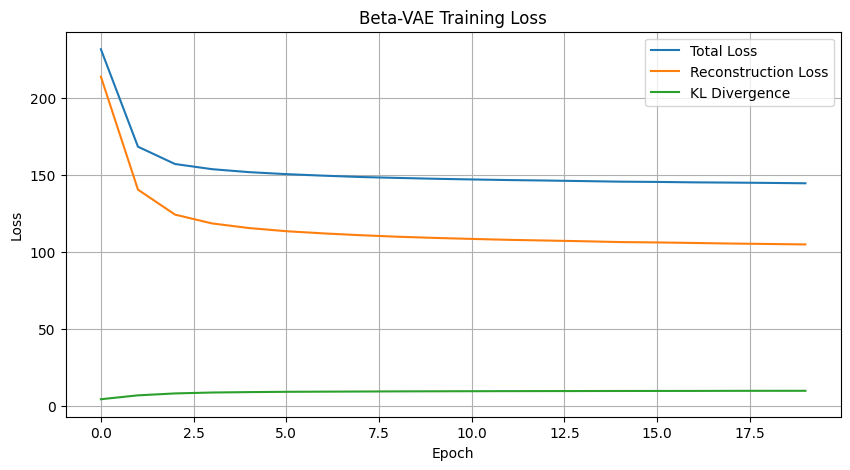

In [13]:
# Plot loss curves  
plt.figure(figsize=(10,5))
plt.plot(losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_divs, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Beta-VAE Training Loss")
plt.grid(True)
plt.show()

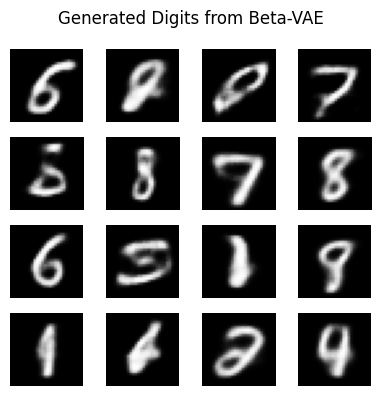

In [14]:
def generate_images(model, num_images=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        samples = model.decode(z)
    model.train()
    return samples.cpu()

samples = generate_images(model)

# Plot generated digits
plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits from Beta-VAE")
plt.tight_layout()
plt.show()